In [1]:
import torch
from models.UNet import UNet
from data_prep.preprocess import *
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import DataLoader, random_split
from torch import Tensor
from torch import optim


# Load data

In [2]:
n_classes = 3

train_loader, test_loader = Preprocess().get_data_loaders(mask_classes=n_classes, use_simple_mask=False)

input_height = 600
input_width = 400
input_features = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [5]:
# compute class weights
def compute_class_weights(train_loader, n_classes):
    class_counts = torch.zeros(n_classes).to(device)
    for _, mask in train_loader:
        mask = mask.to(device)
        for i in range(n_classes):
            class_counts[i] += torch.sum(mask[:, i, :, :] == 1)
    total_pixels = torch.sum(class_counts)
    class_weights = total_pixels / (n_classes * class_counts)
    print(class_weights)
    return class_weights

In [6]:
class_weights = compute_class_weights(train_loader, n_classes)

tensor([7.2208e-02, 2.4027e+01, 2.4508e+00, 8.4733e+01, 8.4814e-01, 3.3073e+00,
        1.8537e+00, 2.1924e+00, 9.6567e+01, 1.1297e+01, 1.1388e+01, 4.6545e+00,
        6.1772e+00, 6.2476e+00, 7.6860e+00, 7.6390e+00, 5.0762e+00, 3.2159e+01],
       device='mps:0')


In [7]:
class_weights

tensor([7.2208e-02, 2.4027e+01, 2.4508e+00, 8.4733e+01, 8.4814e-01, 3.3073e+00,
        1.8537e+00, 2.1924e+00, 9.6567e+01, 1.1297e+01, 1.1388e+01, 4.6545e+00,
        6.1772e+00, 6.2476e+00, 7.6860e+00, 7.6390e+00, 5.0762e+00, 3.2159e+01],
       device='mps:0')

# Define the model

In [3]:
""" Parts of the U-Net model """


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    

In [25]:
""" Full assembly of the parts to form the complete network """


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        

In [5]:

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


# Train

In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        mask_pred = F.one_hot(outputs.argmax(dim=1), n_classes).permute(0, 3, 1, 2).float()
        # compute the Dice score, ignoring background
        #loss += multiclass_dice_coeff(outputs[:, 1:], labels[:, 1:], reduce_batch_first=False)
        loss += dice_loss(
            F.softmax(outputs, dim=1).float(),
            labels.float(),
            multiclass=True
        )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)
    
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            running_loss += criterion(outputs, labels)
    return running_loss / len(test_loader)

In [13]:
epochs = 25
learning_rate=1e-5
weight_decay=1e-8
gradient_clipping=1.0
model = UNet(n_channels=3, n_classes=n_classes)
train_losses = []
test_losses = []
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(weight=class_weights)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(loss)
    print(f"Train Loss: {loss}")
    test_loss = test(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss}")
    test_losses.append(test_loss)
    #if epoch % 5 == 0:
    #  torch.save(model.state_dict(), f'/content/gdrive/MyDrive/18classModel_epoch_{epoch}.pth')
    #  metrics = compute_metrics(model, test_loader, device, n_classes=18)
    #  with open(f'/content/gdrive/MyDrive/18class_epoch_{epoch}_metrics.pkl', 'wb') as file:
    #    pickle.dump(metrics, file)
    #  print(f"Saved model at epoch {epoch}")

Epoch 1


KeyboardInterrupt: 

# Load Model Weights

In [26]:
model = UNet(n_channels=3, n_classes=3)
weights_file = '../weights/3classModel1k.pth'
model.load_state_dict(torch.load(weights_file, map_location=device))
model = model.to(device)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [7]:
import numpy as np

def compute_metrics(model, test_loader, device, n_classes):
    model.eval()
    ious = []
    dice_scores = []
    total_dice = 0
    total_iou = 0
    accuracies = np.zeros(n_classes)
    with torch.no_grad():
        for images, true_masks in test_loader:
            images, true_masks = images.to(device), true_masks.to(device, dtype=torch.long)
            pred_masks = model(images)
            mask_true = true_masks
            mask_pred = F.one_hot(pred_masks.argmax(dim=1), n_classes).permute(0, 3, 1, 2).float()
            # compute the Dice score, ignoring background
            total_dice += multiclass_dice_coeff(pred_masks[:, 1:], true_masks[:, 1:], reduce_batch_first=False)
            # compute the accuracy per class
            for mask_class in range(n_classes):
                # Select only the pixels that are classified as that class in both the predicted and true masks
                mask_pred_class = mask_pred[:, mask_class]
                mask_true_class = mask_true[:, mask_class]
                mask_overlap = mask_pred_class.int() & mask_true_class.int()
                
                # Compute the accuracy for the selected pixels
                mask_overlap = mask_pred_class.int() & mask_true_class.int()

                # Compute the accuracy for the selected pixels
                if mask_true_class.sum().item() > 0:  # Only compute accuracy for classes that appear in the mask
                    accuracies[mask_class] += (mask_overlap.sum().item() / mask_true_class.sum().item())
            # compute the IoU per class
            intersection = (mask_pred * mask_true).sum(dim=(1, 2, 3))
            union = mask_pred.sum(dim=(1, 2, 3)) + mask_true.sum(dim=(1, 2, 3)) - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.append(iou.cpu().numpy())
            total_iou += iou.mean().item()
    dice_scores = total_dice / len(test_loader)
    accuracies /= len(test_loader)
    
    return ious, dice_scores, accuracies

In [8]:
# show tensor image
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_image(image, mask=None):
    if image.shape[0] == 1:
        image = image.squeeze(0)
    if image.shape[0] == 3:
        image = image.permute(1, 2, 0)
    if mask is not None:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(image.permute(0, 1, 2))
        ax[1].imshow(mask)
        plt.show()
    else:
        plt.imshow(image.permute(0, 1, 2))
        plt.show()

In [9]:
def show_mask_comparison(mask, output):
    n_classes = mask.shape[0]
    fig, ax = plt.subplots(n_classes, 2)
    for i in range(n_classes):
        ax[i, 0].imshow(mask[i])
        ax[i, 1].imshow(output[i])
    plt.show()
    
def show_mask_comparison_per_class(mask, output, class_idx):
    n_classes = mask.shape[0]
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(mask[class_idx])
    ax[1].imshow(output[class_idx])
    plt.show()
    
def show_output_mask(output):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(output[0])
    plt.show()

In [19]:
from PIL import Image
image_file = "../images/example_img3.jpg"
image = Image.open(image_file)

In [20]:
def prepare_image(image):
    mean = torch.tensor([0.593, 0.567, 0.534])
    std = torch.tensor([0.247, 0.247, 0.247])
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((600, 400)),
        transforms.Normalize(mean, std)
    ])
    return img_transform(image).unsqueeze(0)
    

In [21]:
image_tensor = prepare_image(image)

In [22]:
model = model.to(device)
output = model(image_tensor.to(device)).argmax(dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


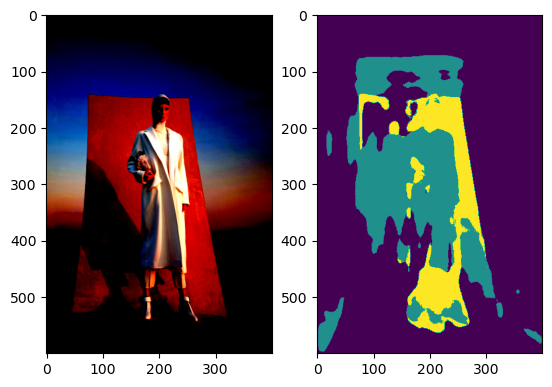

In [23]:
show_image(image_tensor, output.cpu().squeeze(0))

In [27]:
import pickle

with open('../3class_epoch_5_metrics.pkl', 'rb') as file:
    metrics = pickle.load(file)

In [28]:
metrics[2]

array([0.91134448, 0.83882515, 0.90301445])